**Action Recognition and pose estimation**<br>
**Aim of the Project**<br>
Aim of this project is to automatically
recognize human actions based on
analysis of the body landmarks using
pose estimation.<br>
Learning Outcome<br>
1. Implementation of Convolutional Neural Network based pose estimation for body
landmark detection<br>
2. Implementation of pose features-based action recognition and its improvement using
graphical feature representation and data augmentation of body landmarks<br>
3. Preparation and preprocessing of image datasets<br>
4. Fine tuning and improvement of the action recognition model with better feature
representation and data augmentation<br>
5. Development, error analysis and deep learning model improvement<br>

 To attain the afore mentioned aim of the project I will be building a neural network that will predict 3D human poses using 2D images. This with the help of transfer learning by using the VGG16 model architecture and modifying it accordingly for our current problem. By the end of this exercice we will have a deep learning (DL) model that does a really good job of predicting human poses.<br><br>
 
 Creating necessary folders as required for the project files upload.

In [1]:
import os
path=os.getcwd()
print("Current Directory",os.getcwd())
newDir=path+'/dataset/'
os.mkdir(newDir)
print("New Directory created as /content/dataset/")

Current Directory /content
New Directory created as /content/dataset/


In [0]:
if not os.path.exists(os.path.join(os.getcwd(), '/content/data/')):
  os.mkdir('/content/data/')
if not os.path.exists(os.path.join(os.getcwd(), '/content/data/input/')):
  os.mkdir('/content/data/input/')

For this task, we will be using images from Frames Labeled In Cinema (FLIC). These images are not ready to be used for modeling just yet. We will only be estimating the pose of arms, shoulders, and the head. <br><br>
The Full Dataset of FLIC is being used for this project , which is around 1.2 GB in size and it cannot be downloaded directly to the project folder and there by I have kept the same inside my google drive folder under the path /content/drive/My Drive/FLIC-full.zip after downloading the same from the link http://bensapp.github.io/flic-dataset.html
<br> Running below code to link google drive folder with colab folder so us to save the download and upload time for a huge data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In below step I will be creating extracting the zip files from google drive folder to current directory /content/ under the dataset folder

In [5]:
import os
print("Current Directory",os.getcwd())
from zipfile import ZipFile
zf = ZipFile('/content/drive/My Drive/FLIC-full.zip', 'r')
zf.extractall('/content/dataset')
zf.close()
print("Completed Extracting of files to /content/dataset folder")
newDirTrain=path+'/dataset/FLIC-full/train/'
newDirTest=path+'/dataset/FLIC-full/test/'
os.mkdir(newDirTrain)
os.mkdir(newDirTest)
print("New Directories created as ",newDirTrain,' and ',newDirTest)

Current Directory /content
Completed Extracting of files to /content/dataset folder
New Directories created as  /content/dataset/FLIC-full/train/  and  /content/dataset/FLIC-full/test/


**Importing the dependencies** <br>We will be using numpy, matplotlib, keras, tensorflow,tqdm etc packages in this exercise.<br>Below impoar statements will import necessary python libraries as used in this project in various places

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import glob
import h5py
from scipy.io import loadmat
import numpy as np
import pandas as pd
import cv2 as cv
from __future__ import print_function

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras import applications
K.clear_session()

Using TensorFlow backend.


**Exploring and pre-processing the data**<br> With the FLIC-full data folder downloaded and unpacked, inside the FLIC-full folder we can find the examples.mat MATLAB file, and also the folder named images, inside which are the images that will be used in this project.
<br> 
It is also important that you set seed values for reproducibility of the code.
<br>Below given steps are added for meeting afore mentioned targets


In [7]:
# set seed for reproducibility
seed_val = 9000
np.random.seed(seed_val)
random.seed(seed_val)
# load the examples file
examples = loadmat('/content/dataset/FLIC-full/examples.mat')
# print type of the loaded file
print('examples variable is of', type(examples))
# print keys in the dictionary examples
print('keys in the dictionary examples:\n', examples.keys())
# print type and shape of values in examples key
print('Shape of value in examples key: ',examples['examples'].shape)
# print examples
print('Type: ',type(examples['examples']))
# reshape the examples array 
examples = examples['examples'].reshape(-1,)
# print shape of examples array
print("Shape of reshaped 'examples' array:", examples.shape)

examples variable is of <class 'dict'>
keys in the dictionary examples:
 dict_keys(['__header__', '__version__', '__globals__', 'examples'])
Shape of value in examples key:  (1, 20928)
Type:  <class 'numpy.ndarray'>
Shape of reshaped 'examples' array: (20928,)


The notable thing here is that the value of the examples key is a numpy array of shape (1, 20928). You will also see that the array has been reshaped to shape (20928,). The examples key contains the IDs of the images (in the images folder) and the corresponding pose coordinates that can be used for modeling. Let's print out an image ID and its corresponding coordinates array with its shape. The image ID we need is stored at index 3, and the corresponding coordinates are at index 2.
<br>
<br>From below printout statements, we can see that the MATLAB file has been loaded as a dictionary with four keys, one of which is the one we need: the examples key.<br>Let's examin what this key holds

In [8]:
print('Coordinates at location 3 of example 0:\n' ,examples[0][2].T)

print('\n Data type in which the coordinates are stored: ',type(examples[0][2]))

print('\n Shape of the coordinates:', examples[0][2].shape)

print('\n Name of the image file the above coordinates correspond to :\n ',examples[0][3][0])

Coordinates at location 3 of example 0:
 [[436.58776855 195.15625   ]
 [446.54693604 286.796875  ]
 [456.50613403 322.65625   ]
 [265.28979492 203.125     ]
 [277.24081421 328.6328125 ]
 [380.81634521 336.6015625 ]
 [434.59591675 370.46875   ]
 [         nan          nan]
 [         nan          nan]
 [325.04492188 386.40625   ]
 [         nan          nan]
 [         nan          nan]
 [400.73471069 129.4140625 ]
 [374.84082031 125.4296875 ]
 [         nan          nan]
 [         nan          nan]
 [384.80001831 145.3515625 ]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]]

 Data type in which the coordinates are stored:  <class 'numpy.ndarray'>

 Shape of the coordinates: (2, 29)

 Name 

From the above screenshot, we can see that the coordinates array is of shape (2,29):

In [9]:
# each coordinate corresponds to the the below listed body joints/locations in the same order
joint_labels = ['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'lhip',
                'lkne', 'lank', 'rhip', 'rkne', 'rank', 'leye', 'reye',
                'lear', 'rear', 'nose', 'msho', 'mhip', 'mear', 'mtorso',
                'mluarm', 'mruarm', 'mllarm', 'mrlarm', 'mluleg', 'mruleg',
                'mllleg', 'mrlleg']

# print joint_labels
print(joint_labels)

['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'lhip', 'lkne', 'lank', 'rhip', 'rkne', 'rank', 'leye', 'reye', 'lear', 'rear', 'nose', 'msho', 'mhip', 'mear', 'mtorso', 'mluarm', 'mruarm', 'mllarm', 'mrlarm', 'mluleg', 'mruleg', 'mllleg', 'mrlleg']


But, if you look back at the coordinates array that we printed in the preceding screenshot, out of the 29 coordinates, we only have information on 11 of the body joints/locations. These are as follows:

In [10]:
# print list of known joints
known_joints = [x for i,x in enumerate(joint_labels) if i in np.r_[0:7, 9, 12:14, 16]]
print(known_joints)
# print needed joints for the task
target_joints = ['lsho', 'lelb', 'lwri', 'rsho', 'relb',
                 'rwri', 'leye', 'reye', 'nose']
print('Joints necessary for the project:\n', target_joints)

# print the indices of the needed joints in the coordinates array
joints_loc_id = np.r_[0:6, 12:14, 16]
print('\nIndices of joints necessary for the project:\n',joints_loc_id)

['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'lhip', 'rhip', 'leye', 'reye', 'nose']
Joints necessary for the project:
 ['lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri', 'leye', 'reye', 'nose']

Indices of joints necessary for the project:
 [ 0  1  2  3  4  5 12 13 16]


The short codes used above are explained below<br>lsho: Left shoulder <br>lelb: Left elbow <br>lwri: Left wrist <br>rsho: Right shoulder <br>relb: Right elbow <br>rwri: Right wrist <br>leye: Left eye <br>reye: Right eye <br>nose: Nose 

Defining a function that takes in a dictionary of nine joint labels and coordinates and returns a list with seven coordinates (7 (x,y) pairs). The reason for seven coordinates is that the leye, reye, and the nose coordinates are converted into one head coordinate when we take the mean across them

In [0]:
def joint_coordinates(joint):
    """Store necessary coordinates to a list"""
    joint_coor = []
    # Take mean of the leye, reye, nose to obtain coordinates for the head
    joint['head'] = (joint['leye']+joint['reye']+joint['nose'])/3
    joint_coor.extend(joint['lwri'].tolist())
    joint_coor.extend(joint['lelb'].tolist())
    joint_coor.extend(joint['lsho'].tolist())
    joint_coor.extend(joint['head'].tolist())
    joint_coor.extend(joint['rsho'].tolist())
    joint_coor.extend(joint['relb'].tolist())
    joint_coor.extend(joint['rwri'].tolist())
    return joint_coor


Usual projects uses tr_plus_indices.mat file for getting better accuracy which usually comes with FLIC dataset. But due to the non availability of the same I have used an alretnate code to generate testing indices and training indices as a random numpy array as shown below

In [0]:
N_test = int(len(examples) * 0.1)
testing_indices = np.random.permutation(int(len(examples)))[:N_test].tolist()

In the below snippet, we first initialize four empty lists, two for saving train and test image IDs, and two for saving train and test joints. Then, for each data point in the examples key, we do the following: <br>Extract the file name.<br>1. Extract the joint coordinates.<br>2. ZIP the target joints (target joint labels) and the corresponding joint coordinates<br>3. Convert them into a dictionary. <br>Feed the dictionary to the joint_coordinates function to obtain the joints4. needed for this task.<br> Append the image IDs and the resulting joints from the previous step to a train5. or test list by using the train_indices list. Finally, convert the lists into train and test data frames and save them as a CSV file. <br>Make sure that you don't set the index and header parameters to False when saving the data frame as a CSV file

In [0]:
# empty list to store train image ids
train_ids = []
# empty list to store train joints
train_jts = []
# empty list to store test image ids
test_ids = []
# empty list to store test joints
test_jts = []

for i, example in enumerate(examples):
    # image id
    file_name = example[3][0]
    # joint coordinates
    joint = example[2].T
    # dictionary that goes into the joint_coordinates function
    joints = dict(zip(target_joints, [x for k,x in enumerate(joint) if k in joints_loc_id]))
    # obtain joints for the task
    joints = joint_coordinates(joints)
    # use train indices list to decide if an image is to be used for training or testing
    if i not in testing_indices:
        train_ids.append(file_name)
        train_jts.append(joints)
    else:
        test_ids.append(file_name)
        test_jts.append(joints)

# Concatenate image ids dataframe and the joints dataframe and save it as a csv
train_df = pd.concat([pd.DataFrame(train_ids),pd.DataFrame(train_jts)], axis=1)
test_df = pd.concat([pd.DataFrame(test_ids),pd.DataFrame(test_jts)], axis=1)

train_df.to_csv('/content/dataset/FLIC-full/train/train_joints.csv', index=False, header = False)
test_df.to_csv('/content/dataset/FLIC-full/test/test_joints.csv', index=False, header = False)

In below step we wil load the train_joints.csv and test_joints.csv files we saved in the previous step and print out some details:


In [14]:
# load train_joints.csv
train_data = pd.read_csv('/content/dataset/FLIC-full/train/train_joints.csv', header=None)

# load test_joints.csv
test_data = pd.read_csv('/content/dataset/FLIC-full/test/test_joints.csv', header = None)

# train image ids
train_image_ids = train_data[0].values
print('train_image_ids shape', train_image_ids.shape)

# train joints
train_joints = train_data.iloc[:,1:].values
print('train_image_ids shape', train_joints.shape)

# test image ids
test_image_ids = test_data[0].values
print('train_image_ids shape', test_image_ids.shape)

# test joints
test_joints = test_data.iloc[:,1:].values
print('train_image_ids shape', test_joints.shape)

train_image_ids shape (18836,)
train_image_ids shape (18836, 14)
train_image_ids shape (2092,)
train_image_ids shape (2092, 14)


Now, let's load some images from the images folder and plot them to see what they look like:


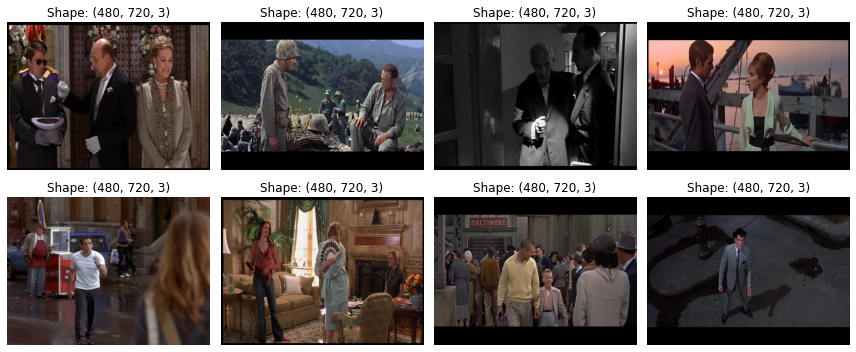

In [15]:
import glob
image_list = glob.glob('/content/dataset/FLIC-full/images/*.jpg')[0:8]

plt.figure(figsize=(12,5))
for i in range(8):
    plt.subplot(2,4,(i+1))
    img = plt.imread(image_list[i])
    plt.imshow(img, aspect='auto')
    plt.axis('off')
    plt.title('Shape: '+str(img.shape))

plt.tight_layout()
plt.show()

We can see that each image is of shape (480*720*3). <br>Our next task will be to crop the original image and focus on the person of interest by using the joint coordinates that are available to us. <br>We do this by resizing the images into a shape of 224*24*3 so that we can feed them into the VGG16 model. <br>Finally, we will also build a plotting function to plot the joints on the image:


In [0]:
def image_cropping(image_id, joints, crop_pad_inf = 1.4, crop_pad_sup=1.6, shift = 5, min_dim = 100):
    """Function to crop original images"""
    ## image cropping
    # load the image 
    image = cv.imread('/content/dataset/FLIC-full/images/%s' % (image_id))
    # convert joint list to array 
    joints = np.asarray([int(float(p)) for p in joints])
    # reshape joints to shape (7*2)
    joints = joints.reshape((len(joints) // 2, 2))
    # transform joints to list of (x,y) tuples
    posi_joints = [(j[0], j[1]) for j in joints if j[0] > 0 and j[1] > 0]
    # obtain the bounding rectangle using opencv boundingRect
    x_loc, y_loc, width, height = cv.boundingRect(np.asarray([posi_joints]))
    if width < min_dim:
        width = min_dim
    if height < min_dim:
        height = min_dim

    ## bounding rect extending
    inf, sup = crop_pad_inf, crop_pad_sup
    r = sup - inf
    # define width padding
    pad_w_r = np.random.rand() * r + inf # inf~sup
    # define height padding
    pad_h_r = np.random.rand() * r + inf # inf~sup
    # adjust x, y, w and h by the defined padding
    x_loc -= (width * pad_w_r - width) / 2
    y_loc -= (height * pad_h_r - height) / 2
    width *= pad_w_r
    height *= pad_h_r

    ## shifting
    x_loc += np.random.rand() * shift * 2 - shift
    y_loc += np.random.rand() * shift * 2 - shift

    ## clipping
    x_loc, y_loc, width, height = [int(z) for z in [x_loc, y_loc, width, height]]
    x_loc = np.clip(x_loc, 0, image.shape[1] - 1)
    y_loc = np.clip(y_loc, 0, image.shape[0] - 1)
    width = np.clip(width, 1, image.shape[1] - (x_loc + 1))
    height = np.clip(height, 1, image.shape[0] - (y_loc + 1))
    image = image[y_loc: y_loc + height, x_loc: x_loc + width]

    ## joint shifting
    # adjust joint coordinates onto the padded image
    joints = np.asarray([(j[0] - x_loc, j[1] - y_loc) for j in joints])
    joints = joints.flatten()

    return image, joints

**Preparing the data** <br>Now let's implement the functions that will perform the tasks that we discussed when we ended the previous section.<br>
**Cropping** <br>We will first start off with the image_cropping() function. This function accepts an image ID and its corresponding joint coordinates. It loads the image into memory and then crops the image so that it only includes the section of the image that's bound within the coordinates. The cropped image is then padded so that the joints and limbs are completely visible. For the added padding, the joint coordinates are also adjusted accordingly. When it has done this, the image is returned. This is the most important part of the transformation. Take your time and dissect the function to see exactly what is happening (the crop_pad_inf and crop_pad_sup parameters control the amount of padding):
<br>Let's pass an image ID and its joints to the image_cropping() function and plot the output image:

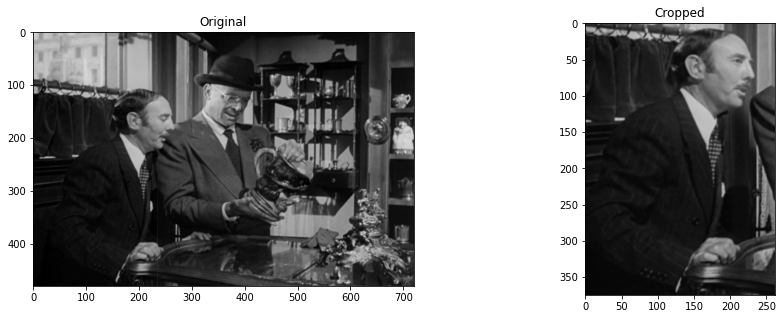

In [17]:
# plot the original image 
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(plt.imread('/content/dataset/FLIC-full/images/'+train_image_ids[0]))

# plot the cropped image
image, joint = image_cropping(train_image_ids[1], train_joints[1])
plt.subplot(1,2,2)
plt.title('Cropped')
plt.imshow(image)

**Resizing** <br>In the Cropping section, we saw that the original image of shape (480*720*3) is cropped to shape (393*254*3). However, the VGG16 architecture accepts images of shape (224*224*3). Hence, we will define a function called image_resize() that does the resizing for us. It accepts the cropped image and the joint resulting from the image_cropping() function as input and returns the resized image and its joint coordinates:


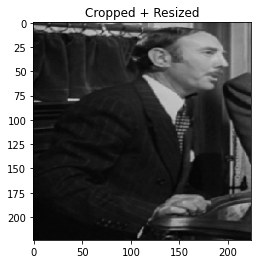

In [18]:
def image_resize(image, joints, new_size = 224):
    """Function resize cropped images"""
    orig_h, orig_w = image.shape[:2]
    joints[0::2] = joints[0::2] / float(orig_w) * new_size
    joints[1::2] = joints[1::2] / float(orig_h) * new_size
    image = cv.resize(image, (new_size, new_size), interpolation=cv.INTER_NEAREST)
    return image, joints
# plot resized image
image, joint = image_resize(image, joint)
plt.title('Cropped + Resized')
plt.imshow(image)

After passing the cropped image to the image_resize() function, we can see that the resulting image is of shape (224*224*3). Now this image and its joints can be passed into the model for training.<br><br>
**Plotting the joints and limbs** <br>Let's also define the plotting functions that will plot the limbs on the resized image. The following defined plot_joints() function accepts the resized image and its joints and returns an image of the same shape with the limbs plotted on top:


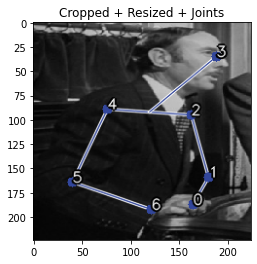

In [19]:
def plot_limb(img, joints, i, j, color):
    """Function to plot the limbs"""
    cv.line(img, joints[i], joints[j], (255, 255, 255), thickness=2, lineType=16)
    cv.line(img, joints[i], joints[j], color, thickness=1, lineType=16)
    return img

def plot_joints(img, joints, groundtruth=True, text_scale=0.5):
    """Function to draw the joints"""
    h, w, c = img.shape
    if groundtruth:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 155, 70))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 155, 70))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 155, 70))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 155, 70))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 155, 70))
        
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 155, 70))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 155, 70), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=2, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    else:
        # left hand to left elbow
        img = plot_limb(img, joints, 0, 1, (50, 70, 155))
        
        # left elbow to left shoulder
        img = plot_limb(img, joints, 1, 2, (50, 70, 155))
        
        # left shoulder to right shoulder
        img = plot_limb(img, joints, 2, 4, (50, 70, 155))
        
        # right shoulder to right elbow
        img = plot_limb(img, joints, 4, 5, (50, 70, 155))
        
        # right elbow to right hand
        img = plot_limb(img, joints, 5, 6, (50, 70, 155))
       
        # neck coordinate
        neck = tuple((np.array(joints[2]) + np.array(joints[4])) // 2)
        joints.append(neck)
        
        # neck to head
        img = plot_limb(img, joints, 3, 7, (50, 70, 155))
        joints.pop()

        # joints
        for j, joint in enumerate(joints):
            # plot joints
            cv.circle(img, joint, 5, (50, 70, 155), -1)
            # plot joint number black
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (0, 0, 0), thickness=3, lineType=16)
            # plot joint number white
            cv.putText(img, '%d' % j, joint, cv.FONT_HERSHEY_SIMPLEX, text_scale,
                       (255, 255, 255), thickness=1, lineType=16)

    return img
# plot joints on resized image
joints = joint.tolist()
joints = list(zip(joints[0::2], joints[1::2]))

plt.title('Cropped + Resized + Joints')
plt.imshow(plot_joints(image, joints, groundtruth=False, text_scale=0.5))

**Transforming the images** <br>Now let's transform the images and their corresponding joints to the desired form by using the functions we have defined previously. We will do this with the help of the model_data() function, which is defined as follows:


In [0]:
def model_data(image_ids, joints, train = True):
    """Function to generate train and test data."""
    if train:
        # empty list 
        train_img_joints = []
        
        # create train directory inside FLIC-full
        if not os.path.exists(os.path.join(os.getcwd(), '/content/dataset/FLIC-full/train')):
            os.mkdir('/content/dataset/FLIC-full/train')

        for i, (image, joint) in enumerate(zip(image_ids, joints)):
            # crop the image using the joint coordinates
            image, joint = image_cropping(image, joint)
            
            # resize the cropped image to shape (224*224*3)
            image, joint = image_resize(image, joint)
            
            # save the image in train folder
            cv.imwrite('/content/dataset/FLIC-full/train/train{}.jpg'.format(i), image)
            
            # store joints and image id/file name of the saved image in the initialized list
            train_img_joints.append(['train{}.jpg'.format(i)] + joint.tolist())
        
        # convert to a dataframe and save as a csv
        pd.DataFrame(train_img_joints).to_csv('/content/dataset/FLIC-full/train/train_joints.csv', index=False, header=False)
    else:
        # empty list 
        test_img_joints = []
        
        # create test directory inside FLIC-full
        if not os.path.exists(os.path.join(os.getcwd(), '/content/dataset/FLIC-full/test')):
            os.mkdir('/content/dataset/FLIC-full/test')
        
        for i, (image, joint) in enumerate(zip(image_ids, joints)):
            # crop the image using the joint coordinates
            image, joint = image_cropping(image, joint)
            
            # resize the cropped image to shape (224*224*3)
            image, joint = image_resize(image, joint)
            
            # save the image in test folder
            cv.imwrite('/content/dataset/FLIC-full/test/test{}.jpg'.format(i), image)
            
            # store joints and image id/file name of the saved image in the initialized list
            test_img_joints.append(['test{}.jpg'.format(i)] + joint.tolist())
            
        # convert to a dataframe and save as a csv
        pd.DataFrame(test_img_joints).to_csv('/content/dataset/FLIC-full/test/test_joints.csv', index=False, header=False)


model_data(train_image_ids, train_joints, train = True)
model_data(test_image_ids, test_joints, train = False)

**Defining hyperparameters for training** <br>Clearing the session and the following are some of the hyperparameters that have been defined that we will be using throughout our code. These are totally configurable:<br>Also downloads the VGG16 model as vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [21]:
K.clear_session()
epochs = 3
# Batchsize
batch_size = 128
# Optimizer for the model
optimizer = Adam(lr=0.0001, beta_1=0.5)
# Shape of the input image
input_shape = (224, 224, 3)
# Batch interval at which loss is to be stores
store = 40

# load the vgg16 model 
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = input_shape)




58892288/58889256 [==============================] - 2s 0us/step








**Building the VGG16 model** <br>The VGG16 model is a deep convolution neural network image classifier. The model uses a combination of Conv2D, MaxPooling2D, and Dense layers to form the final architecture, and the activation function that's used is ReLU. It accepts color images of shape 224*224*3, and is capable of predicting 1,000 classes. This means that the final Dense layer has 1,000 neurons, and it uses softmax activation to get scores for each class.
Defining the VGG16 model In this project, we want to feed in images of shape 224*224*3 and be able to predict the joint coordinates for the body in the image. That is, we want to be able to predict 14 numerical values (7 (x,y) pairs). Therefore, we modify the final Dense layer to have 14 neurons and use ReLU activation instead of sigmoid. Training a deep learning model such as VGG16 can take up to a week on a local machine. This is a lot of time. An alternative to this in our case is to use the weights of a trained VGG16 model through transfer learning. 

In [22]:
# print summary of vgg16 model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

As a next step, flatten the output of the preceding section of the model and then add three Dense layers, of which two layers have 1,024 neurons each with a dropout between them, and a final Dense layer with 14 neurons to obtain the 14 joint coordinates. We will only be training the weights of the layers defined in the following code snippet:


In [23]:
# set layers as non trainable
for layer in model.layers:
    layer.trainable = False

# Adding custom Layers
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)

# Dense layer with 14 neurons for predicting 14 numeric values
predictions = Dense(14, activation="relu")(x)
# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)
# print summary
model_final.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________

Once all of the layers have been defined and configured, we will combine them by using the Model function in Keras, as follows<br><br>
**Training loop** <br>Now that the VGG16 model is all set to be used for training, let's load the train_joints.csv file from the train folder containing the IDs of the cropped and resized images with their joint coordinates. Then, split the data into an 80:20 train and validation set by using the train_test_split module from sklearn. We imported it with the other imports at the beginning of this project. Since the validation data is small, load all of the corresponding images into memory: <br><br>
We will now define the training() function, which will train the VGG16 model on the train images. This function accepts the VGG16 model, train image IDs, train joints, validation images, and validation joints as parameters. The following steps define what is happening in the training() function: <br>The function defines empty lists by using loss_lst to store the train loss<br>1. and val_loss_lst to store the validation loss. It also defines a counter count to keep track of the total number of batches. It then creates a batch of train image IDs and their corresponding joints.<br>2. Using the batch image IDs, it loads the corresponding images into memory by<br>3. using the OpenCV imread() function. It then converts the loaded train images into a float, which it feeds along with<br>4. the joint IDs to the train_on_batch() function of the model for the fit. At every 40th batch, it evaluates the model on the validation data and stores the<br>5. train and validation loss in the defined lists. It then repeats Steps 2 through 5 for the desired number of epochs

In [24]:
# compile the model 
model_final.compile(loss = "mean_squared_error", optimizer = optimizer)
# load the train data
train = pd.read_csv('/content/dataset/FLIC-full/train/train_joints.csv', header = None)

# split train into train and validation
train_img_ids, val_img_ids, train_jts, val_jts = train_test_split(train.iloc[:,0], train.iloc[:,1:], test_size=0.2, random_state=42)

# load validation images
val_images = np.array([cv.imread('/content/dataset/FLIC-full/train/{}'.format(x)) for x in val_img_ids.values])

# convert validation images to dtype float 
val_images = val_images.astype(float)

def training(model, image_ids, joints ,val_images, val_jts, batch_size = 128, epochs=3, store = 40):
    # empty train loss list
    loss_lst = []
    
    # empty validation loss list
    val_loss_lst = []
    
    #counter
    count = 0
    count_lst = []
    
    # create shuffled batches
    batches = np.arange(len(image_ids)//batch_size)
    data_idx = np.arange(len(image_ids))
    random.shuffle(data_idx)
    print('......Training......')
    for epoch in range(epochs):
        for batch in (batches):
            # batch of training image ids
            imgs = image_ids[data_idx[batch*batch_size : (batch+1)*batch_size:]]
            
            # corresponding joints for the above images
            jts = joints[data_idx[batch*batch_size : (batch+1)*batch_size:]]
            
            # load the training image batch
            batch_imgs = np.array([cv.imread('/content/dataset/FLIC-full/train/{}'.format(x)) for x in imgs])

            # fit model on the batch
            loss = model.train_on_batch(batch_imgs.astype(float), jts)
            
            if batch%store==0:
                # evaluate model on validation set
                val_loss = model.evaluate(val_images, val_jts, verbose = 0, batch_size=batch_size)
                
                # store train and val loss
                loss_lst.append(loss)
                val_loss_lst.append(val_loss)
                print('Epoch:{}, End of batch:{}, loss:{:.2f}, val_loss:{:.2f}'.format(epoch+1, batch+1, loss, val_loss))
                
                count_lst.append(count)
            else:
                print('Epoch:{}, End of batch:{}, loss:{:.2f}'.format(epoch+1, batch+1, loss))
            count+=1
    count_lst.append(count)
    loss_lst.append(loss)
    val_loss = model.evaluate(val_images, val_jts, verbose = 0, batch_size=batch_size)
    val_loss_lst.append(val_loss)
    print('Epoch:{}, End of batch:{}, VAL_LOSS:{:.2f}'.format(epoch+1, batch+1, val_loss))
    return model, loss_lst, val_loss_lst, count_lst

Now fit the model and run epochs and batches and save the results to corresposnding variables

In [25]:
m, loss_lst, val_loss_lst, count_lst = training(model_final, train_img_ids.values, train_jts.values, val_images, val_jts.values, epochs = epochs, batch_size = batch_size, store = store)

......Training......


Epoch:1, End of batch:1, loss:15391.45, val_loss:13006.68
Epoch:1, End of batch:2, loss:12919.21
Epoch:1, End of batch:3, loss:10011.41
Epoch:1, End of batch:4, loss:6905.05
Epoch:1, End of batch:5, loss:4806.29
Epoch:1, End of batch:6, loss:3438.43
Epoch:1, End of batch:7, loss:3110.90
Epoch:1, End of batch:8, loss:3156.59
Epoch:1, End of batch:9, loss:2267.56
Epoch:1, End of batch:10, loss:2282.70
Epoch:1, End of batch:11, loss:1959.06
Epoch:1, End of batch:12, loss:1968.96
Epoch:1, End of batch:13, loss:1978.03
Epoch:1, End of batch:14, loss:1938.30
Epoch:1, End of batch:15, loss:1916.14
Epoch:1, End of batch:16, loss:1648.98
Epoch:1, End of batch:17, loss:1883.13
Epoch:1, End of batch:18, loss:1867.36
Epoch:1, End of batch:19, loss:1566.82
Epoch:1, End of batch:20, loss:1555.76
Epoch:1, End of batch:21, loss:1700.68
Epoch:1, End of batch:22, loss:1447.37
Epoch:1, End of batch:23, loss:1493.92
Epoch:1, End of batch:24, loss:1588.72
Epoch:1, End of batch:25, lo

**Plot training and validation loss** <br>With loss_lst and val_loss_lst containing the train and validation MSE loss at intervals of 40 batches, let's plot this and see how the learning has progressed

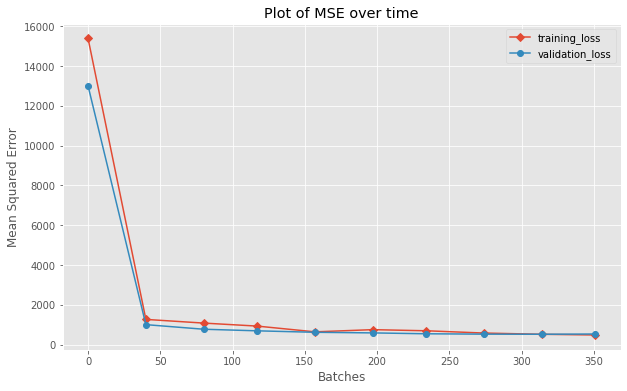

In [26]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(count_lst, loss_lst, marker='D', label = 'training_loss')
plt.plot(count_lst, val_loss_lst, marker='o', label = 'validation_loss')
plt.xlabel('Batches')
plt.ylabel('Mean Squared Error')
plt.title('Plot of MSE over time')
plt.legend(loc = 'upper right')
plt.show()

**Predictions**
<br>***Making test predictions***<br>We will define a function that takes the model as input and tests the model on the test data we have preprocessed and saved in the test folder. Along with predictions, it will also save test images with the true and predicted joints plotted on it by using the plot_limb() and the plot_joints() functions we defined in the preceding section:


In [0]:
def test(model, nrows=200, batch_size=batch_size):
    # load the train data
    test = pd.read_csv('/content/dataset/FLIC-full/test/test_joints.csv', header = None, nrows=nrows)
    test_img_ids = test.iloc[:,0].values
    
    # load validation images
    test_images = np.array([cv.imread('/content/dataset/FLIC-full/test/{}'.format(x)) for x in test_img_ids])

    # convert validation images to dtype float 
    test_images = test_images.astype(float)
    
    # joints
    test_joints = test.iloc[:,1:].values
    
    # evaluate
    test_loss = model.evaluate(test_images, test_joints, verbose = 0, batch_size=batch_size)
    
    # predict
    predictions = model.predict(test_images, verbose = 0, batch_size=batch_size)
    # folder to save the results
    if not os.path.exists(os.path.join(os.getcwd(), '/content/dataset/FLIC-full/test_plot')):
        os.mkdir('/content/dataset/FLIC-full/test_plot')
    
    for i, (ids, image, joint, pred) in enumerate(zip(test_img_ids, test_images, test_joints, predictions)):
        joints = joint.tolist()
        joints = list(zip(joints[0::2], joints[1::2]))
        # plot original joints
        image = plot_joints(image.astype(np.uint8), joints, groundtruth=True, text_scale=0.5)
        
        pred = pred.astype(np.uint8).tolist()
        pred = list(zip(pred[0::2], pred[1::2]))
        # plot predicted joints
        image = plot_joints(image.astype(np.uint8), pred, groundtruth=False, text_scale=0.5)
        # save resulting images with the same id
        plt.imsave('/content/dataset/FLIC-full/test_plot/'+ids, image)
    return test_loss

On a test set with 200 images, the test MSE loss is ~ 450, which is very close to the validation MSE loss of ~ 560, indicating that the model is not overfitting on the train data

In [29]:
# test and save results
test_loss = test(m)

# print test_loss
print('Test Loss:', test_loss)

Test Loss: 565.5867211914062


Now let's plot the images we saved during testing to get a measure of how the true joints compare to the predicted joints

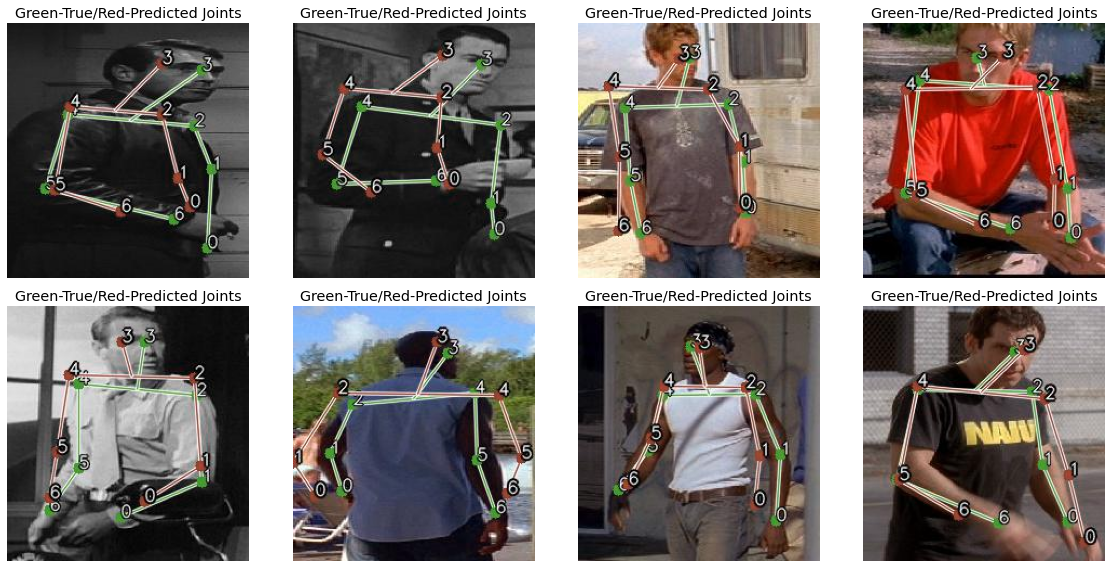

In [30]:
image_list = glob.glob('/content/dataset/FLIC-full/test_plot/*.jpg')[8:16]

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(2,4,(i+1))
    img = cv.imread(image_list[i])
    plt.imshow(img, aspect='auto')
    plt.axis('off')
    plt.title('Green-True/Red-Predicted Joints')

plt.tight_layout()
plt.show()

Now we will save the model as json file(human_deeppose_model.json) to disk as well as the .h5 file(human_deeppose_model.h5) so that the model can be reused later. This saves time and memory consumption.

In [31]:
# save model
model_json = m.to_json()
# folder to save the results
if not os.path.exists(os.path.join(os.getcwd(), '/content/dataset/FLIC-full/model/')):
    os.mkdir('/content/dataset/FLIC-full/model/')
with open("/content/dataset/FLIC-full/model/human_deeppose_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights
m.save_weights("/content/dataset/FLIC-full/model/human_deeppose_model.h5")
print("Saved model to disk")

Saved model to disk


Below given is the code for reloading any saved model in json or h5 format from the local disk to program

In [32]:
## Load saved model
from keras.models import model_from_json

# load json and create model
json_file = open('/content/dataset/FLIC-full/model/human_deeppose_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights
loaded_model.load_weights("/content/dataset/FLIC-full/model/human_deeppose_model.h5")
print("Loaded model from disk")
 
# compile the model
loaded_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5),
                     loss='mean_squared_error')

Loaded model from disk


**2. NN based Action Recognition model** <br>
Now lets try to build a Nural network based Action recognition/classification model. The steps taken below are
<br>Load the dataset with pose joints as features and actions labels (‘Namaste’ vs ‘Hello’).<br>Split the 
dataset into training and testing and Training the model for few epochs, test the model, saving the 
model.

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.models import Model,Sequential
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import *
%matplotlib inline

Load the dataset and is label encoding the cetegorical field label as integer values of 1 and 2

In [0]:
# load the dataset
dataset = pd.read_csv('/content/data/input/action_joints.csv')
dataset1=dataset.drop('url',axis=1)
target=dataset1['label']
dataset1=dataset1.drop('label',axis=1)
target=target.replace({'Hello': 1, 'Namaste': 2})

Now Split the 
dataset into training and testing and Train the model for few epochs, test the model, save the 
model as actions_model.h5 to local disk

In [35]:
# split into input (X) and output (y) variables
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = dataset1
y = target
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=3, verbose=0)

# make class predictions with the model
predictions = model.predict_classes(X_train)
model.save('/content/dataset/FLIC-full/model/human_actions_model.h5')
y_train_pred = model.predict(X_test)
print(accuracy_score(y_test, y_train_pred))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0.6


Since the accuracy is very lowas 60 % we need to consider the  data 
augmentation to increase the accuracy where further graph-like features are extracted from the dataset.

Now lets try to extract the frames from the Video Waving.mp4

In [0]:
import cv2
 
# Opens the Video file
cap= cv2.VideoCapture('/content/data/input/Waving.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('/content/data/input/Waveing'+str(i)+'.jpg',frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

# Project Synopsis and Summary and Conclusion

**AIM of the project and problem statement**<br>
**Aim of the Project**<br>
Aim of this project is to automatically
recognize human actions based on
analysis of the body landmarks using
pose estimation.<br>
Learning Outcome<br>
1. Implementation of Convolutional Neural Network based pose estimation for body
landmark detection<br>
2. Implementation of pose features-based action recognition and its improvement using
graphical feature representation and data augmentation of body landmarks<br>
3. Preparation and preprocessing of image datasets<br>
4. Fine tuning and improvement of the action recognition model with better feature
representation and data augmentation<br>
5. Development, error analysis and deep learning model improvement<br>
**Problem Statement**<br>
Analysis of people’s actions and activities in public and private environments are highly 
necessary for security. This cannot be done manually as the number of cameras for surveillance 
produce lengthy hours of video feed every day. Real-time detection and alerting of suspicious 
activities or actions are also challenging in these scenarios. This issue can be solved by applying 
deep learning-based algorithms for action recognition. 

**Solution Implemented**<br>
***1.Human Pose Estimation***<br>
Like most computer vision problems today, the state-of-the-art approach towards the pose estimation problem is to use a deep learning network called Convolutional Neural Network (CNN). A CNN model is the backbone of any AI-enabled video analytics solution and it needs to be trained using hundreds of thousands of annotated datasets before it can be of any use. There are many open source annotated datasets that support the development of CNN models.<br>
***2.Human Action Recognition***<br>
Every human action, no matter how trivial, is done for
some purpose. For example, in order to complete a physical
exercise, a patient is interacting with and responding to the
environment using his/her hands, arms, legs, torsos, bodies, etc.
An action like this denotes everything that can be observed, either
with bare eyes or measured by visual sensors. Through human
vision system, we can understand the action and the purpose of
the actor. One of the ultimate goals of artificial intelligence research
is to build a machine that can accurately understand humans’
actions and intentions, so that it can better serve us.


**Architecture Used**<br>
Convolution operation is one of the fundamental components
in deep networks for action recognition, which aggregates pixel
values in a small spatial (or spatiotemporal) neighborhood using a
kernel matrix. 2D vs 3D Convolution: 2D convolution over images is one of the basic operation in deep networks,
and thus it is straightforward to use 2D convolution on video
frames. The work in  presented a single-frame architecture
based on 2D CNN model, and extracted a feature vector for
each frame. As multiple frames are presenting in videos, 3D convolution
is more intuitive to capture temporal dynamics in
a short period of time. Using 3D convolution, 3D convolutional
networks (3D ConvNets) directly create hierarchical representations of spatio-temporal data.
The CNN network based architecture is used to resolve the problem of Human pose estimation and an Nural Network (NN) based architecture is used to provide solution for Human action recognition in this project.


 **Real-World Applications**<br>
 Pose & Action recognition and prediction algorithms empower many realworld application<br>
*   Assisted living <br>Personal care robots may be deployed in future assisted living homes.
*   Video games <br>Commercially, pose estimation has been used in the context of video games, popularized with the Microsoft Kinect sensor (a depth camera). These systems track the user to render their avatar in-game.
*   Visual Surveillance<br>Security issue is becoming more important in our daily life, and
it is one of the most frequently discussed topics nowadays. Places
under surveillance typically allow certain human actions, and
other actions are not allowed
*   Video Retrieval<br>
Nowadays, due to fast growth of technology, people can easily
upload and share videos on the Internet. However, managing
and retrieving videos according to video content is becoming a
tremendous challenge as most search engines use the associated
text data to manage video data
*    Human-Robot Interaction<br>Human-robot interaction is popularly applied in home and industry
environment
*    Autonomous Driving Vehicle<br>
Action prediction algorithms could be one of the
potential and may be most important building components in
an autonomous driving vehicle.

**Conclusion**<br>This project was all about building a convolutional neural network (CNN) classifier to solve the problem of estimating 3D human poses using frames captured from movies as well as to predict the action from photos and videos. Our hypothetical use case was to enable visual effects specialists to easily estimate the pose of actors (from their shoulders, necks, and heads from the frames in a video. Our task was to build the intelligence for this application<br>
The modified VGG16 architecture we built using transfer learning has a test mean squared error loss of ~ 450 squared units over 200 test images for each of the 14 coordinates (that is, the 7(x, y) pairs). We can also say that the test root mean squared error over 200 test images for each of the 14 coordinates is 21.326 units.The root mean squared error (RMSE), in this case, is a measure of how far off the predicted joint coordinates/joint pixel location are from the actual joint coordinate/joint pixel location. 


**Summary**<br>In this chapter, we successfully built a deep convolution neural network/VGG16 model in Keras on FLIC images. We got hands-on experience in preparing these images for modeling. We successfully implemented transfer learning, and understood that doing so will save us a lot of time. We defined some key hyperparameters as well in some places, and reasoned about why we used what we used. Finally, we tested the modified VGG16 model performance on unseen data and determined that we succeeded in achieving our goals. Also defined a new NN based model for action recognition as well as video action recognition

**References**<br>
[1] Matthew Lamons, Rahul Kumar, Abhishek Nagaraja - Python Deep Learning Projects , July 2018<br>
[2] TASWEER AHMAD, HUIYUN MAO2, LUOJUN LIN1, GUOZHI TANG - Action Recognition using Attention - Joints Graph Convolutional Neural Networks<br>
[3] Md Matiqul Islam1 , Antony Lam, Hisato Fukuda, Yoshinori Kobayashi and Yoshinori Kuno - An intelligent shopping support robot<br>
[4]Wanqing Li ,Zhengyou Zhang, Zicheng Liu - Action Recognition Based on A Bag of 3DPoints<br>
[5] Online medias such as kaggle, medium, analytics vidya etc.
